In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # type: ignore # linear algebra
import pandas as pd # type: ignore # data processing, CSV file I/O (e.g. pd.read_csv)

a classification label, with possible values 

In [2]:
emo_la={0:'frustration',1:'neutral',2:'anger',3:'sadness',4:'excitment',5:'happiness'}

In [3]:
emo_la[0]

'frustration'

# Exploratory_Data_Analysis

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('IEMOCAP/iemocap.csv')

# First, split the dataset into training and remaining sets
# Calculate the number of samples for the remaining set (validation + testing)
remaining_size = 1000 + 1523

# Split off the remaining set from the original dataset
train_data, remaining_data = train_test_split(data, test_size=remaining_size, random_state=42)

# Now split the remaining data into validation and testing sets
val_data, test_data = train_test_split(remaining_data, test_size=1523, random_state=42)

# The size of val_data will be 1000
# The size of test_data will be 1523

# Save the splits to CSV files if needed
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Display the first few rows of the splits
print("Training Data:")
print(train_data.head())

print("\nValidation Data:")
print(val_data.head())

print("\nTest Data:")
print(test_data.head())

Training Data:
     label                                               text Sentiment
4039   exc   Oh God.  Annie, I kissed Annie.  I kissed Annie.  positive
2697   neu  Tell me, did you see much of Peter Burden afte...   neutral
2185   neu  Uh- it didn't make it into the second plane so...   neutral
3298   neu  Carla, can I ask you something? Don't take thi...   neutral
1231   fru  It's not just me, okay?  Look at like all the ...  negative

Validation Data:
     label                                               text Sentiment
1844   ang  God damn it, Augie, don't ask me that.  I hate...  negative
1483   fru  It's just so frustrating.  Like, I just--I jus...  negative
3164   hap             I've been ready for a long, long time.  positive
7012   neu                           I completely understand.   neutral
7373   ang                               Very amusing indeed.  negative

Test Data:
     label                                               text Sentiment
2903   sad  Kind of

In [5]:
data['label'].value_counts()

label
fru    1849
neu    1708
ang    1103
sad    1084
exc    1041
hap     595
Name: count, dtype: int64

In [6]:
data['Sentiment'].value_counts() 

Sentiment
negative    4036
neutral     1708
positive    1636
Name: count, dtype: int64

In [7]:
data

label                                               text Sentiment
0      neu                                         Excuse me.   neutral
1      neu                                              Yeah.   neutral
2      neu                                Is there a problem?   neutral
3      neu        Well what's the problem?  Let me change it.   neutral
4      fru  What?  I'm getting an ID.  This is why I'm her...  negative
...    ...                                                ...       ...
7375   ang  You are a vile tempered, wicked living, evil l...  negative
7376   ang                    Oh, you're not going like this.  negative
7377   ang                          [GARBAGE] No, you're not.  negative
7378   ang  oh! Marry you again? I wouldn't marry you agai...  negative
7379   ang  You're a wicked little vampire.  And I pray to...  negative

[7380 rows x 3 columns]

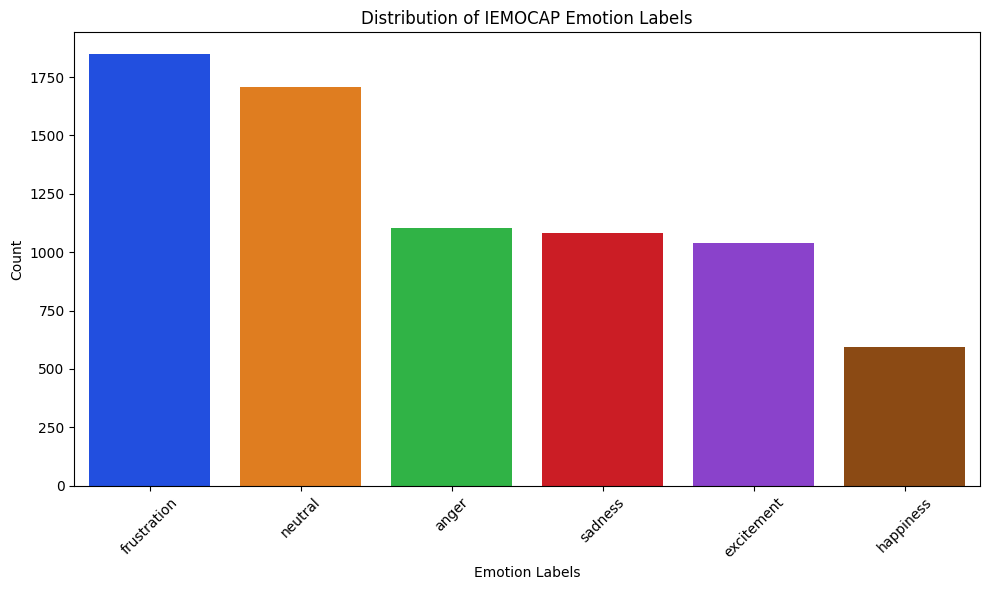

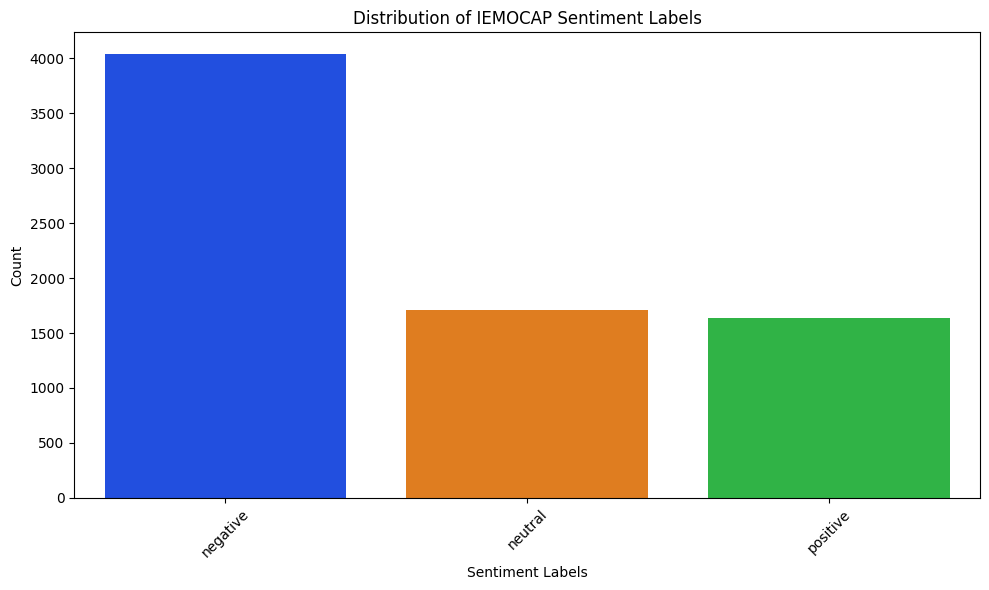

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Actual class counts for emotions and corresponding labels
class_counts = [1849, 1708, 1103, 1084, 1041, 595]
emo_la = {0: 'frustration', 1: 'neutral', 2: 'anger', 3: 'sadness', 4: 'excitement', 5: 'happiness'}

# Assuming the sentiment distribution (this should be replaced with actual sentiment counts)
sentiment_counts = [4036, 1708, 1636]  # Example counts: [neutral, positive, negative]
sentiment_labels = ['negative','neutral', 'positive']

# Create DataFrame for the emotion labels and their counts
emotion_data = pd.DataFrame({
    'label': [emo_la[i] for i in range(len(class_counts))],
    'count': class_counts
})

# Create DataFrame for the sentiment labels and their counts
sentiment_data = pd.DataFrame({
    'Sentiment': sentiment_labels,
    'count': sentiment_counts
})

# Plotting the distribution of Emotion Labels
plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='count', data=emotion_data, hue='label', palette=sns.color_palette("bright", len(emotion_data)), dodge=False, legend=False)
plt.xlabel('Emotion Labels')
plt.ylabel('Count')
plt.title('Distribution of IEMOCAP Emotion Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the distribution of Sentiment Labels
plt.figure(figsize=(10, 6))
sns.barplot(x='Sentiment', y='count', data=sentiment_data, hue='Sentiment', palette=sns.color_palette("bright", len(sentiment_data)), dodge=False, legend=False)
plt.xlabel('Sentiment Labels')
plt.ylabel('Count')
plt.title('Distribution of IEMOCAP Sentiment Labels')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
val_data['label'].value_counts()

label
fru    246
neu    225
ang    153
sad    151
exc    134
hap     91
Name: count, dtype: int64

In [10]:
import nlpaug.augmenter.word as naw

# Initialize random word augmenter with delete action
masking_aug = naw.RandomWordAug(action='delete')

def augment_text_with_masking(text):
    # Augment the given text using random masking
    augmented_text = masking_aug.augment(text)
    
    return augmented_text

# Original text
original_text = 'I am now nearly finished the week detox and I feel amazing'

# Augment the original text
augmented_text = augment_text_with_masking(original_text)

# Print original and augmented text
print("Original:")
print(original_text)
print("\nAugmented Text (Random Masking):")
print(augmented_text)

Original:
I am now nearly finished the week detox and I feel amazing

Augmented Text (Random Masking):
['Am finished the week detox and feel amazing']


# DistilBert Multi Tasking Emotion & Sentiment

In [20]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, DistilBertConfig, DistilBertModel, get_cosine_schedule_with_warmup
from torch.optim import AdamW
from torch.amp import GradScaler, autocast
import numpy as np

# Hyperparameters
batch_size = 64
epochs = 16
lr = 2e-5
eps = 1e-8
max_grad_norm = 1.0
num_emotion_classes = 6
num_sentiment_classes = 3
gamma = 2.0  # Focal loss gamma
emotion_weight, sentiment_weight = 0.7, 0.3  # Multi-task loss weighting

# Data preparation (Assume data, val_data, and test_data are provided as pandas DataFrames)
X_train = data['text']
y_train_emotion = data['label']
y_train_sentiment = data['Sentiment']
X_val = val_data['text']
y_val_emotion = val_data['label']
y_val_sentiment = val_data['Sentiment']
X_test = test_data['text']
y_test_emotion = test_data['label']
y_test_sentiment = test_data['Sentiment']

# Mapping emotion labels from strings to integers
emotion_label_map = {
    "fru": 0,  # Frustration
    "neu": 1,  # Neutral
    "ang": 2,  # Anger
    "sad": 3,  # Sadness
    "exc": 4,  # Excitement
    "hap": 5   # Happiness
}
y_train_emotion_mapped = y_train_emotion.map(emotion_label_map)
y_val_emotion_mapped = y_val_emotion.map(emotion_label_map)
y_test_emotion_mapped = y_test_emotion.map(emotion_label_map)
# Mapping sentiment labels from strings to integers
sentiment_label_map = {"negative": 0, "neutral": 1, "positive": 2}
y_train_sentiment_mapped = y_train_sentiment.map(sentiment_label_map)
y_val_sentiment_mapped = y_val_sentiment.map(sentiment_label_map)
y_test_sentiment_mapped = y_test_sentiment.map(sentiment_label_map)

# Tokenizer setup
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_encode(text_list, tokenizer):
    text_list = [str(text) for text in text_list]
    encodings = tokenizer(
        text_list, 
        truncation=True, 
        padding=True, 
        return_tensors='pt', 
        max_length=128
    )
    return encodings['input_ids'], encodings['attention_mask']

X_train_encodings, train_attention_masks = tokenize_and_encode(X_train.tolist(), tokenizer)
X_val_encodings, val_attention_masks = tokenize_and_encode(X_val.tolist(), tokenizer)
X_test_encodings, test_attention_masks = tokenize_and_encode(X_test.tolist(), tokenizer)

# Convert labels to tensors
y_train_emotion_tensor = torch.tensor(y_train_emotion_mapped.values, dtype=torch.long)
y_val_emotion_tensor = torch.tensor(y_val_emotion_mapped.values, dtype=torch.long)
y_train_sentiment_tensor = torch.tensor(y_train_sentiment_mapped.values, dtype=torch.long)
y_val_sentiment_tensor = torch.tensor(y_val_sentiment_mapped.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_encodings, train_attention_masks, y_train_emotion_tensor, y_train_sentiment_tensor)
val_dataset = TensorDataset(X_val_encodings, val_attention_masks, y_val_emotion_tensor, y_val_sentiment_tensor)
y_test_emotion_tensor = torch.tensor(y_test_emotion_mapped.values, dtype=torch.long)
y_test_sentiment_tensor = torch.tensor(y_test_sentiment_mapped.values, dtype=torch.long)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_encodings, test_attention_masks, y_test_emotion_tensor, y_test_sentiment_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class DistilBERTPrototypicalNetwork(nn.Module):
    def __init__(self, config):
        super(DistilBERTPrototypicalNetwork, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(model_name, config=config)
        self.hidden_size = config.hidden_size
        self.dropout = nn.Dropout(0.4)  # Increased dropout for better regularization

    def forward(self, input_ids, attention_mask=None):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state.mean(dim=1)  # Using mean pooling instead of the [CLS] token
        hidden_state = self.dropout(hidden_state)
        return hidden_state

    def compute_prototypes(self, embeddings, labels, num_classes):
        prototypes = []
        for class_idx in range(num_classes):
            class_embeddings = embeddings[labels == class_idx]
            if class_embeddings.size(0) > 0:
                prototype = class_embeddings.mean(dim=0)
                prototypes.append(prototype)
            else:
                prototypes.append(torch.zeros(self.hidden_size).to(embeddings.device) + 1e-6)
        return torch.stack(prototypes)

    def classify(self, query_embeddings, prototypes):
        distances = torch.cdist(query_embeddings, prototypes)
        return distances

def focal_weighted_loss(logits, targets, gamma=2.0, weights=None):
    ce_loss = F.cross_entropy(logits, targets, reduction='none', weight=weights)
    pt = torch.exp(-ce_loss)
    return ((1 - pt) ** gamma * ce_loss).mean()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

config = DistilBertConfig.from_pretrained(model_name)
config.hidden_size = 768
model = DistilBERTPrototypicalNetwork(config).to(device)

optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
total_steps = len(train_dataloader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(0.1 * total_steps), num_training_steps=total_steps)
scaler = GradScaler()

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for step, batch in enumerate(train_dataloader):
        input_ids, attention_masks, emotion_labels, sentiment_labels = (t.to(device) for t in batch)

        with autocast(device_type='cuda'):
            embeddings = model(input_ids, attention_mask=attention_masks)
            embeddings = F.normalize(embeddings, p=2, dim=-1)

            prototypes_emotion = model.compute_prototypes(embeddings, emotion_labels, num_emotion_classes)
            prototypes_sentiment = model.compute_prototypes(embeddings, sentiment_labels, num_sentiment_classes)

            logits_emotion = -torch.cdist(embeddings, prototypes_emotion) / 0.1
            logits_sentiment = -torch.cdist(embeddings, prototypes_sentiment) / 0.1

            loss_emotion = focal_weighted_loss(logits_emotion, emotion_labels, gamma)
            loss_sentiment = focal_weighted_loss(logits_sentiment, sentiment_labels, gamma)
            loss = (emotion_weight * loss_emotion + sentiment_weight * loss_sentiment)

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        total_loss += loss.item()

    scheduler.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

    # Validation Step
    model.eval()
    val_loss, correct_emotion, correct_sentiment, total = 0, 0, 0, 0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_masks, emotion_labels, sentiment_labels = (t.to(device) for t in batch)
            embeddings = model(input_ids, attention_mask=attention_masks)
            embeddings = F.normalize(embeddings, p=2, dim=-1)

            prototypes_emotion = model.compute_prototypes(embeddings, emotion_labels, num_emotion_classes)
            prototypes_sentiment = model.compute_prototypes(embeddings, sentiment_labels, num_sentiment_classes)

            logits_emotion = -torch.cdist(embeddings, prototypes_emotion) / 0.1
            logits_sentiment = -torch.cdist(embeddings, prototypes_sentiment) / 0.1

            val_loss += (focal_weighted_loss(logits_emotion, emotion_labels, gamma) +
                         focal_weighted_loss(logits_sentiment, sentiment_labels, gamma)).item()

            correct_emotion += (logits_emotion.argmax(dim=-1) == emotion_labels).sum().item()
            correct_sentiment += (logits_sentiment.argmax(dim=-1) == sentiment_labels).sum().item()
            total += emotion_labels.size(0)

            # Free up memory
            del embeddings, prototypes_emotion, prototypes_sentiment
            torch.cuda.empty_cache()

    avg_val_loss = val_loss / len(val_dataloader)
    emotion_acc = correct_emotion / total
    sentiment_acc = correct_sentiment / total
    print(f"Validation Loss: {avg_val_loss:.4f}, Emotion Acc: {emotion_acc:.4f}, Sentiment Acc: {sentiment_acc:.4f}")

c:\Users\Muhammad Hussain\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1/16, Loss: 0.6187
Validation Loss: 1.0589, Emotion Acc: 0.7440, Sentiment Acc: 0.7650
Epoch 2/16, Loss: 0.6058
Validation Loss: 1.0270, Emotion Acc: 0.7510, Sentiment Acc: 0.7860
Epoch 3/16, Loss: 0.5608
Validation Loss: 0.9896, Emotion Acc: 0.7440, Sentiment Acc: 0.7630
Epoch 4/16, Loss: 0.5062
Validation Loss: 0.9452, Emotion Acc: 0.7340, Sentiment Acc: 0.7680
Epoch 5/16, Loss: 0.4593
Validation Loss: 0.8821, Emotion Acc: 0.7670, Sentiment Acc: 0.7940
Epoch 6/16, Loss: 0.4273
Validation Loss: 0.8185, Emotion Acc: 0.7740, Sentiment Acc: 0.7860
Epoch 7/16, Loss: 0.4037
Validation Loss: 0.7665, Emotion Acc: 0.7660, Sentiment Acc: 0.7860
Epoch 8/16, Loss: 0.3819
Validation Loss: 0.7304, Emotion Acc: 0.7600, Sentiment Acc: 0.7800
Epoch 9/16, Loss: 0.3616
Validation Loss: 0.7059, Emotion Acc: 0.7560, Sentiment Acc: 0.7710
Epoch 10/16, Loss: 0.3466
Validation Loss: 0.6871, Emotion Acc: 0.7500, Sentiment Acc: 0.7720
Epoch 11/16, Loss: 0.3370
Validation Loss: 0.6664, Emotion Acc: 0.754

In [21]:
# Separate Validation Code
model.eval()
val_loss, correct_emotion, correct_sentiment, total = 0, 0, 0, 0
with torch.no_grad():
    for batch in val_dataloader:
        input_ids, attention_masks, emotion_labels, sentiment_labels = (t.to(device) for t in batch)
        embeddings = model(input_ids, attention_mask=attention_masks)
        embeddings = F.normalize(embeddings, p=2, dim=-1)

        prototypes_emotion = model.compute_prototypes(embeddings, emotion_labels, num_emotion_classes)
        prototypes_sentiment = model.compute_prototypes(embeddings, sentiment_labels, num_sentiment_classes)

        logits_emotion = -torch.cdist(embeddings, prototypes_emotion) / 0.1
        logits_sentiment = -torch.cdist(embeddings, prototypes_sentiment) / 0.1

        val_loss += (focal_weighted_loss(logits_emotion, emotion_labels, gamma) +
                     focal_weighted_loss(logits_sentiment, sentiment_labels, gamma)).item()

        correct_emotion += (logits_emotion.argmax(dim=-1) == emotion_labels).sum().item()
        correct_sentiment += (logits_sentiment.argmax(dim=-1) == sentiment_labels).sum().item()
        total += emotion_labels.size(0)

        # Free up memory
        del embeddings, prototypes_emotion, prototypes_sentiment
        torch.cuda.empty_cache()

avg_val_loss = val_loss / len(val_dataloader)
emotion_acc = correct_emotion / total
sentiment_acc = correct_sentiment / total
print(f"Final Validation Loss: {avg_val_loss:.4f}, Emotion Acc: {emotion_acc:.4f}, Sentiment Acc: {sentiment_acc:.4f}")

Final Validation Loss: 0.5691, Emotion Acc: 0.7780, Sentiment Acc: 0.8020


In [22]:
# Separate Testing Code
model.eval()
test_loss, correct_emotion, correct_sentiment, total = 0, 0, 0, 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_masks, emotion_labels, sentiment_labels = (t.to(device) for t in batch)
        embeddings = model(input_ids, attention_mask=attention_masks)
        embeddings = F.normalize(embeddings, p=2, dim=-1)

        prototypes_emotion = model.compute_prototypes(embeddings, emotion_labels, num_emotion_classes)
        prototypes_sentiment = model.compute_prototypes(embeddings, sentiment_labels, num_sentiment_classes)

        logits_emotion = -torch.cdist(embeddings, prototypes_emotion) / 0.1
        logits_sentiment = -torch.cdist(embeddings, prototypes_sentiment) / 0.1

        test_loss += (focal_weighted_loss(logits_emotion, emotion_labels, gamma) +
                      focal_weighted_loss(logits_sentiment, sentiment_labels, gamma)).item()

        correct_emotion += (logits_emotion.argmax(dim=-1) == emotion_labels).sum().item()
        correct_sentiment += (logits_sentiment.argmax(dim=-1) == sentiment_labels).sum().item()
        total += emotion_labels.size(0)

        # Free up memory
        del embeddings, prototypes_emotion, prototypes_sentiment
        torch.cuda.empty_cache()

avg_test_loss = test_loss / len(test_dataloader)
emotion_acc = correct_emotion / total
sentiment_acc = correct_sentiment / total
print(f"Final Test Loss: {avg_test_loss:.4f}, Emotion Acc: {emotion_acc:.4f}, Sentiment Acc: {sentiment_acc:.4f}")

Final Test Loss: 0.5468, Emotion Acc: 0.7800, Sentiment Acc: 0.7859


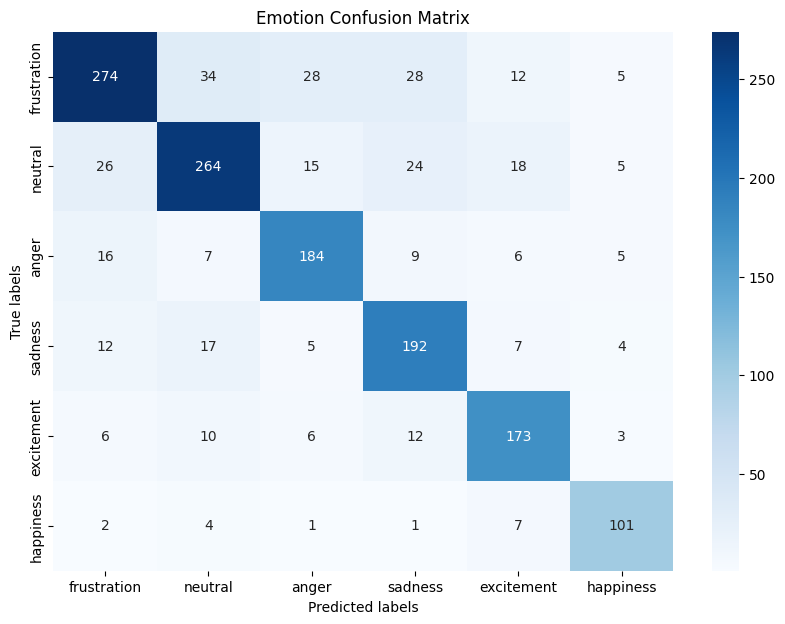

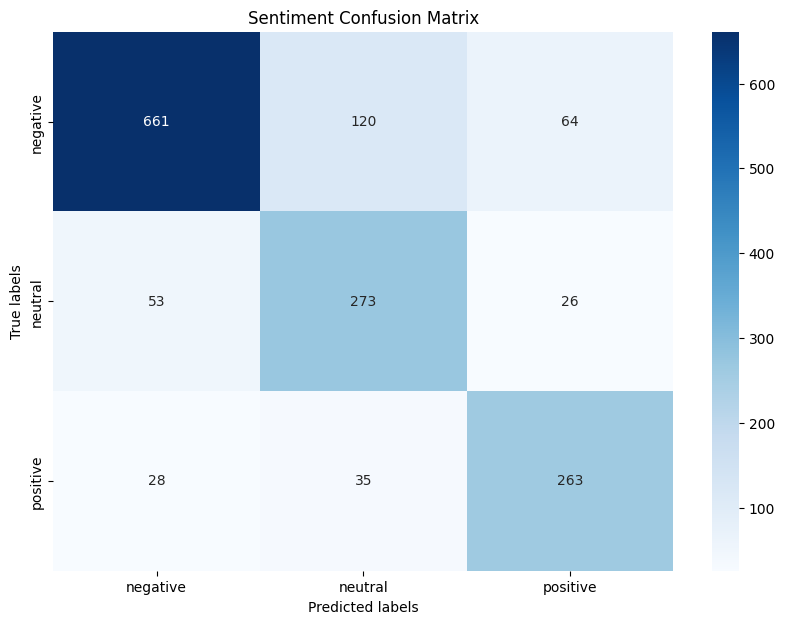

Emotion Classification Report:
              precision    recall  f1-score   support

 frustration       0.82      0.72      0.76       381
     neutral       0.79      0.75      0.77       352
       anger       0.77      0.81      0.79       227
     sadness       0.72      0.81      0.76       237
  excitement       0.78      0.82      0.80       210
   happiness       0.82      0.87      0.85       116

    accuracy                           0.78      1523
   macro avg       0.78      0.80      0.79      1523
weighted avg       0.78      0.78      0.78      1523

Sentiment Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.78      0.83       845
     neutral       0.64      0.78      0.70       352
    positive       0.75      0.81      0.77       326

    accuracy                           0.79      1523
   macro avg       0.76      0.79      0.77      1523
weighted avg       0.80      0.79      0.79      1523



In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)
    plt.show()

def compute_and_plot_confusion_matrices(model, test_dataloader, num_emotion_classes, num_sentiment_classes, device):
    model.eval()  # Ensure model is in evaluation mode
    all_emotion_labels = []
    all_sentiment_labels = []
    all_emotion_preds = []
    all_sentiment_preds = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_masks, emotion_labels, sentiment_labels = batch
            input_ids, attention_masks, emotion_labels, sentiment_labels = (
                input_ids.to(device),
                attention_masks.to(device),
                emotion_labels.to(device),
                sentiment_labels.to(device),
            )

            # Generate embeddings using the model
            embeddings = model(input_ids, attention_mask=attention_masks)
            embeddings = F.normalize(embeddings, p=2, dim=-1)

            # Compute prototypes for emotion and sentiment
            prototypes_emotion = model.compute_prototypes(embeddings, emotion_labels, num_emotion_classes)
            prototypes_sentiment = model.compute_prototypes(embeddings, sentiment_labels, num_sentiment_classes)

            # Compute logits for emotion and sentiment classification
            logits_emotion = -torch.cdist(embeddings, prototypes_emotion) / 0.1
            logits_sentiment = -torch.cdist(embeddings, prototypes_sentiment) / 0.1

            # Get predicted labels for both emotion and sentiment
            _, predicted_emotion = torch.max(logits_emotion, dim=1)
            _, predicted_sentiment = torch.max(logits_sentiment, dim=1)

            # Accumulate true labels and predictions
            all_emotion_labels.extend(emotion_labels.cpu().numpy())
            all_sentiment_labels.extend(sentiment_labels.cpu().numpy())
            all_emotion_preds.extend(predicted_emotion.cpu().numpy())
            all_sentiment_preds.extend(predicted_sentiment.cpu().numpy())

    # Compute confusion matrices
    emotion_cm = confusion_matrix(all_emotion_labels, all_emotion_preds, labels=range(num_emotion_classes))
    sentiment_cm = confusion_matrix(all_sentiment_labels, all_sentiment_preds, labels=range(num_sentiment_classes))

    # Define class names
    emotion_class_names = ['frustration', 'neutral', 'anger', 'sadness', 'excitement', 'happiness']
    sentiment_class_names = ['negative', 'neutral', 'positive']

    # Plot confusion matrices
    plot_confusion_matrix(emotion_cm, emotion_class_names, title='Emotion Confusion Matrix')
    plot_confusion_matrix(sentiment_cm, sentiment_class_names, title='Sentiment Confusion Matrix')

    # Generate classification reports
    emotion_report = classification_report(all_emotion_labels, all_emotion_preds, target_names=emotion_class_names)
    sentiment_report = classification_report(all_sentiment_labels, all_sentiment_preds, target_names=sentiment_class_names)

    print("Emotion Classification Report:")
    print(emotion_report)

    print("Sentiment Classification Report:")
    print(sentiment_report)

# Compute and plot confusion matrices and classification reports for the test dataset
compute_and_plot_confusion_matrices(
    model, test_dataloader, num_emotion_classes, num_sentiment_classes, device
)

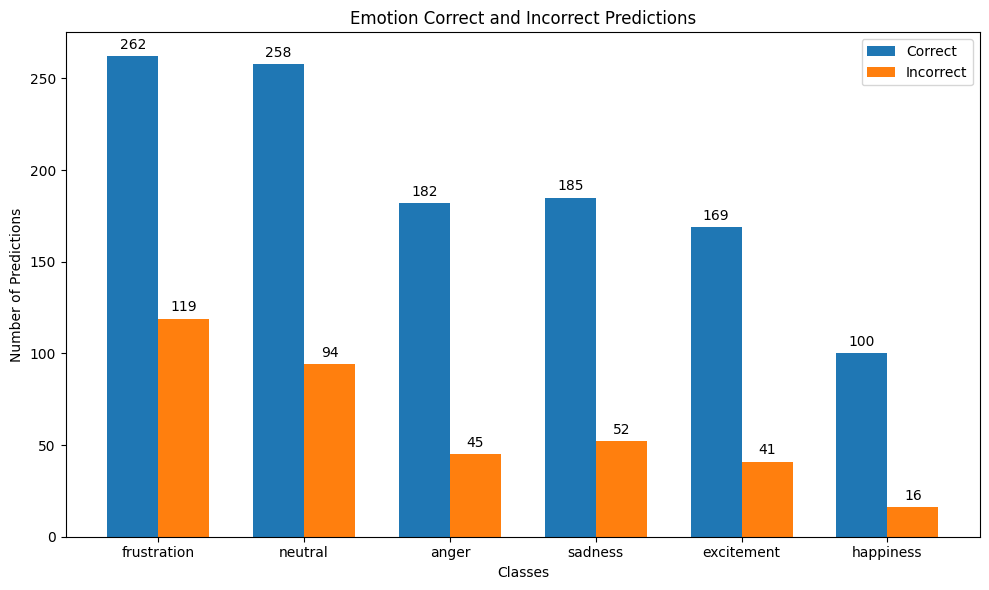

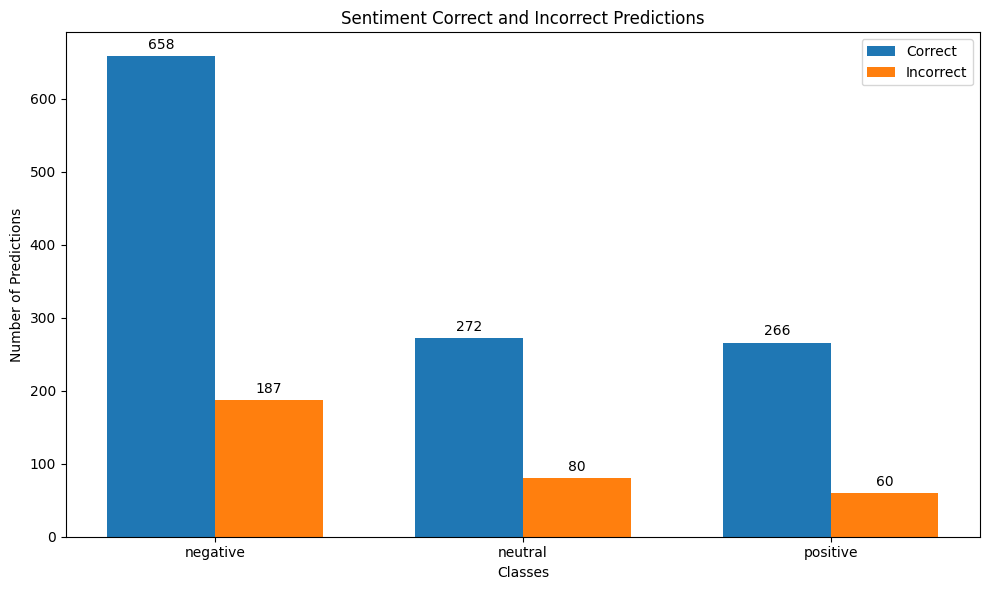

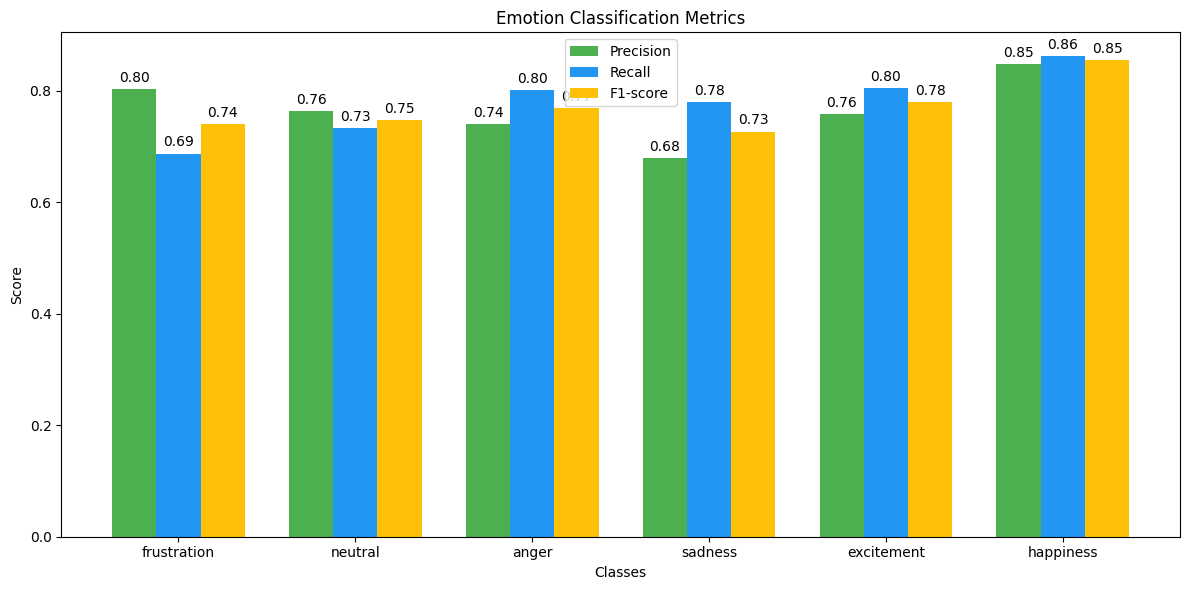

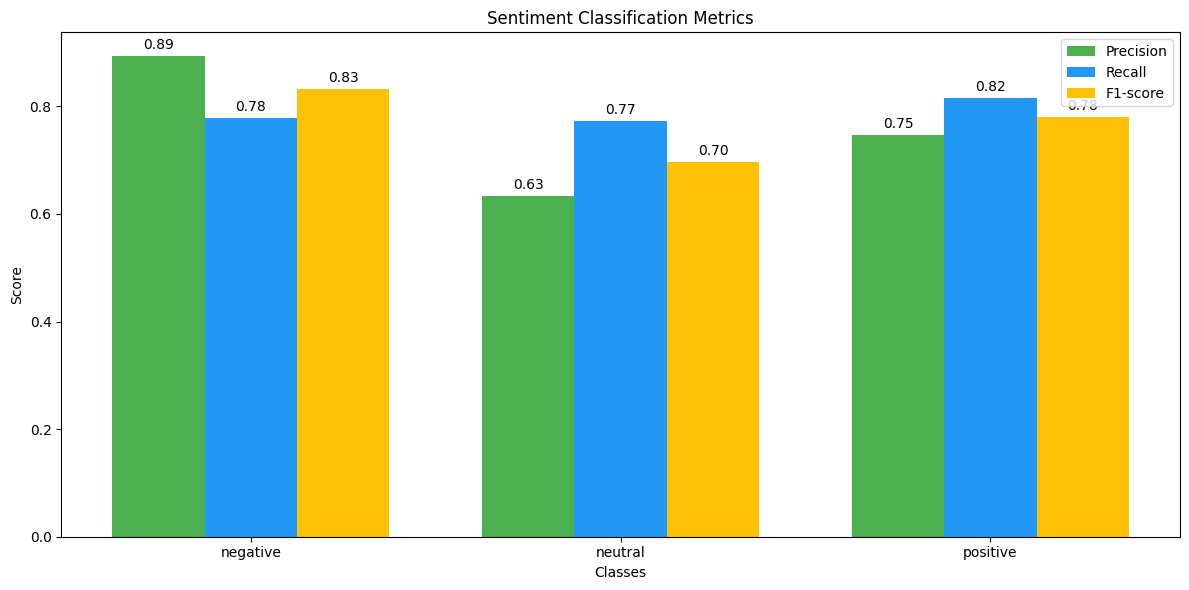

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

def plot_correct_incorrect_predictions(cm, class_names, title='Correct and Incorrect Predictions by Class'):
    # Calculate correct and incorrect predictions per class
    correct_predictions_per_class = np.diag(cm)
    total_predictions_per_class = cm.sum(axis=1)
    incorrect_predictions_per_class = total_predictions_per_class - correct_predictions_per_class

    # Plotting the results
    x = np.arange(len(class_names))  # Label locations
    width = 0.35  # Width of bars

    # Creating the bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width / 2, correct_predictions_per_class, width, label='Correct')
    rects2 = ax.bar(x + width / 2, incorrect_predictions_per_class, width, label='Incorrect')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Classes')
    ax.set_ylabel('Number of Predictions')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()

    # Adding counts above bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{int(height)}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # Offset label position
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)

    # Show plot
    plt.tight_layout()
    plt.show()

def plot_precision_recall_f1(precision, recall, f1, class_names, title='Precision, Recall, and F1-score by Class'):
    x = np.arange(len(class_names))  # Label locations
    width = 0.25  # Width of bars

    # Creating the bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width, precision, width, label='Precision', color='#4CAF50')
    rects2 = ax.bar(x, recall, width, label='Recall', color='#2196F3')
    rects3 = ax.bar(x + width, f1, width, label='F1-score', color='#FFC107')

    # Add labels, title, and custom x-axis tick labels
    ax.set_xlabel('Classes')
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names)
    ax.legend()

    # Adding counts above bars
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # Offset label position
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)
    add_labels(rects3)

    # Show plot
    plt.tight_layout()
    plt.show()

def compute_and_plot_correct_incorrect_predictions(model, test_dataloader, num_emotion_classes, num_sentiment_classes, device):
    model.eval()  # Ensure model is in evaluation mode
    all_emotion_labels = []
    all_sentiment_labels = []
    all_emotion_preds = []
    all_sentiment_preds = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids, attention_masks, emotion_labels, sentiment_labels = batch
            input_ids, attention_masks, emotion_labels, sentiment_labels = (
                input_ids.to(device),
                attention_masks.to(device),
                emotion_labels.to(device),
                sentiment_labels.to(device),
            )

            # Generate embeddings using the model
            embeddings = model(input_ids, attention_mask=attention_masks)
            embeddings = F.normalize(embeddings, p=2, dim=-1)

            # Compute prototypes for emotion and sentiment
            prototypes_emotion = model.compute_prototypes(embeddings, emotion_labels, num_emotion_classes)
            prototypes_sentiment = model.compute_prototypes(embeddings, sentiment_labels, num_sentiment_classes)

            # Compute logits for emotion and sentiment classification
            logits_emotion = -torch.cdist(embeddings, prototypes_emotion) / 0.1
            logits_sentiment = -torch.cdist(embeddings, prototypes_sentiment) / 0.1

            # Get predicted labels for both emotion and sentiment
            _, predicted_emotion = torch.max(logits_emotion, dim=1)
            _, predicted_sentiment = torch.max(logits_sentiment, dim=1)

            # Accumulate true labels and predictions
            all_emotion_labels.extend(emotion_labels.cpu().numpy())
            all_sentiment_labels.extend(sentiment_labels.cpu().numpy())
            all_emotion_preds.extend(predicted_emotion.cpu().numpy())
            all_sentiment_preds.extend(predicted_sentiment.cpu().numpy())

    # Compute confusion matrices
    emotion_cm = confusion_matrix(all_emotion_labels, all_emotion_preds, labels=range(num_emotion_classes))
    sentiment_cm = confusion_matrix(all_sentiment_labels, all_sentiment_preds, labels=range(num_sentiment_classes))

    # Define class names
    emotion_class_names = ['frustration', 'neutral', 'anger', 'sadness', 'excitement', 'happiness']
    sentiment_class_names = ['negative', 'neutral', 'positive']

    # Plot correct and incorrect predictions per class
    plot_correct_incorrect_predictions(emotion_cm, emotion_class_names, title='Emotion Correct and Incorrect Predictions')
    plot_correct_incorrect_predictions(sentiment_cm, sentiment_class_names, title='Sentiment Correct and Incorrect Predictions')

    # Compute Precision, Recall, and F1-score for each class
    emotion_precision, emotion_recall, emotion_f1, _ = precision_recall_fscore_support(all_emotion_labels, all_emotion_preds, labels=range(num_emotion_classes))
    sentiment_precision, sentiment_recall, sentiment_f1, _ = precision_recall_fscore_support(all_sentiment_labels, all_sentiment_preds, labels=range(num_sentiment_classes))

    # Plot Precision, Recall, and F1-score for each class
    plot_precision_recall_f1(emotion_precision, emotion_recall, emotion_f1, emotion_class_names, title='Emotion Classification Metrics')
    plot_precision_recall_f1(sentiment_precision, sentiment_recall, sentiment_f1, sentiment_class_names, title='Sentiment Classification Metrics')

# Compute and plot correct and incorrect predictions for the test dataset
compute_and_plot_correct_incorrect_predictions(
    model, test_dataloader, num_emotion_classes, num_sentiment_classes, device
)